This is inspired by a question from a colleague this week.

I'm going to present a method to exert a bit more control over substructure queries without having to do a massive amount of work.

In [1]:
from rdkit import Chem,DataStructs
import time,random
from collections import defaultdict
import psycopg2
from rdkit.Chem import Draw,PandasTools,rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw,rdqueries
from rdkit import rdBase
from __future__ import print_function
import requests
from xml.etree import ElementTree
import pandas as pd
%load_ext sql
print(rdBase.rdkitVersion)
print(time.asctime())

2015.09.1.dev1
Sat Aug 15 17:54:55 2015


Our starting point is a query against ChEMBL for molecules that contain a phenyl ring with a substituent.

In [2]:
data = %sql postgresql://localhost/chembl_20 \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>'c1ccccc1*'::qmol limit 10;

10 rows affected.


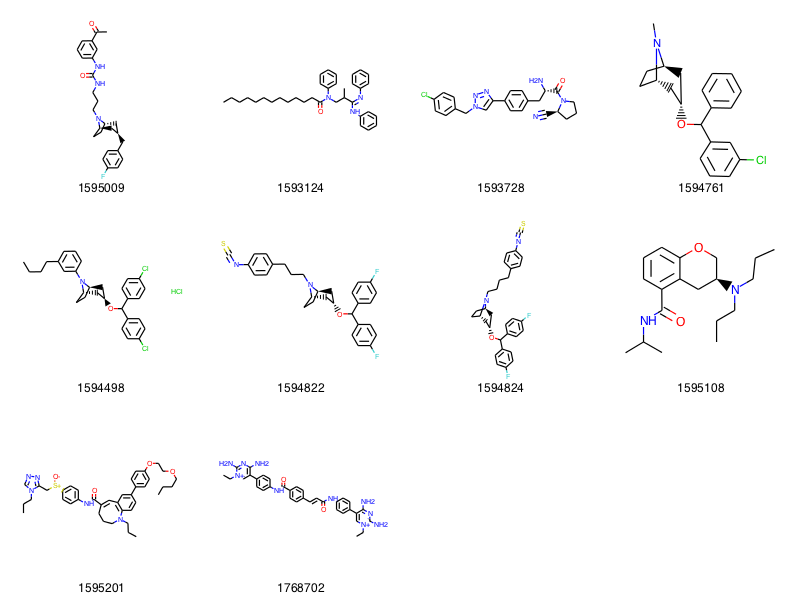

In [3]:
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

Though some of the structures above (1593124 and 1594761) contain the fragment we are looking for, the others all include additional substituents on the phenyl. 

It's straightforward to make the query more specific by hand-editing the SMARTS, here's one example:

10 rows affected.


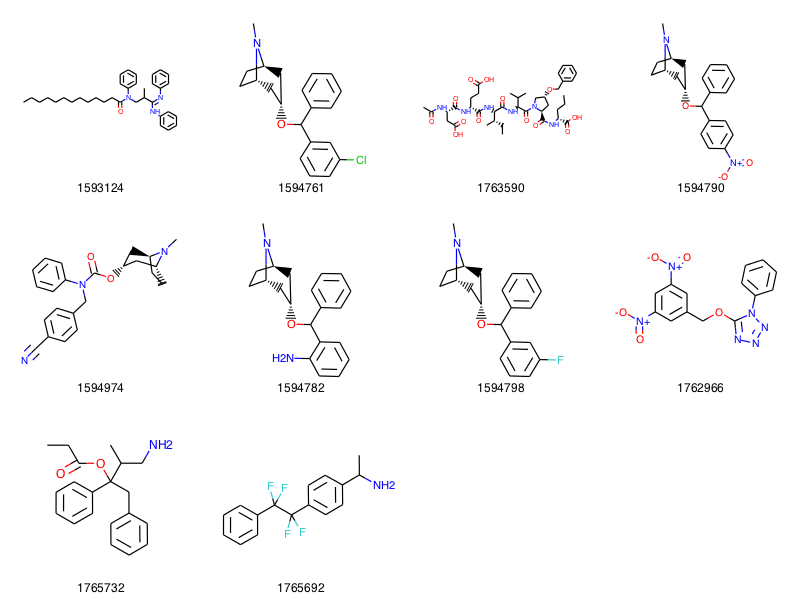

In [4]:
sma = '[cH]1[cH][cH][cH][cH]c1*'
data = %sql  \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>:sma ::qmol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)            

But that would be something of a pain for more complex queries.

Here's another approach, the idea is to modify the query for each non-wildcard atom and specify that its degree should be what is found in the query:

In [5]:
sma = 'c1ccccc1-[*]'
m = Chem.MolFromSmarts(sma)
# start by creating an RWMol:
m = Chem.RWMol(m)
for atom in m.GetAtoms():
    # skip dummies:
    if not atom.GetAtomicNum():
        continue
    atom.ExpandQuery(rdqueries.ExplicitDegreeEqualsQueryAtom(atom.GetDegree()))
sma = Chem.MolToSmarts(m)
print("Result SMARTS:",sma)

Result SMARTS: [c&D2]1:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D3]:,-1-*


This also produces the results we want:

10 rows affected.


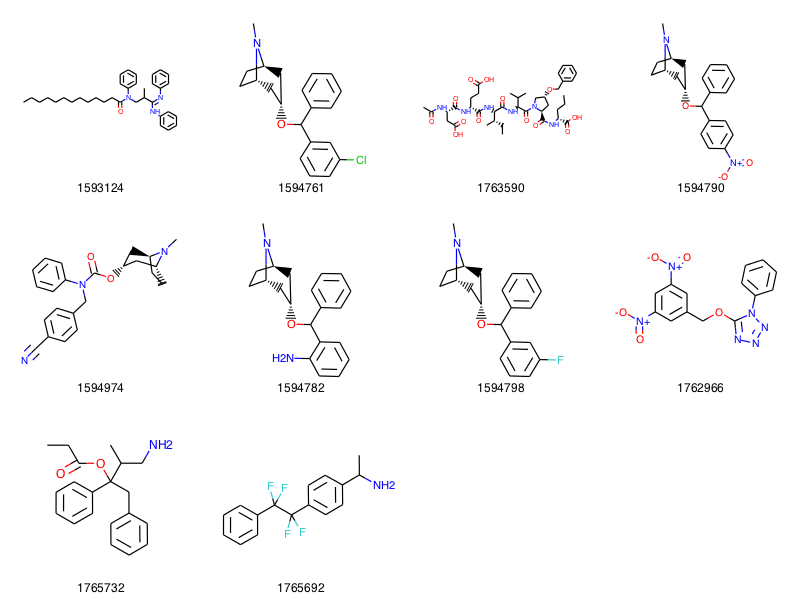

In [6]:
data = %sql  \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>:sma ::qmol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)            


This only works for query atoms (i.e. the molecule must be constructed from SMARTS), but we can adapt it to deal with non-query atoms as well: 

In [7]:
sma = 'c1ccccc1-[*]'
m = Chem.MolFromSmiles(sma)
# start by creating an RWMol:
m = Chem.RWMol(m)
for atom in m.GetAtoms():
    # skip dummies:
    if not atom.GetAtomicNum():
        continue
    oa = atom
    if not atom.HasQuery():
        needsReplacement=True
        atom = rdqueries.AtomNumEqualsQueryAtom(oa.GetAtomicNum())
        atom.ExpandQuery(rdqueries.IsAromaticQueryAtom(oa.GetIsAromatic()))
        if(oa.GetIsotope()):
            atom.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(oa.GetIsotope()))
        if(oa.GetFormalCharge()):
            atom.ExpandQuery(rdqueries.FormalChargeEqualsQueryAtom(oa.GetFormalCharge()))
    else:
        needsReplacement=False
    atom.ExpandQuery(rdqueries.ExplicitDegreeEqualsQueryAtom(oa.GetDegree()))
    if needsReplacement:
        m.ReplaceAtom(oa.GetIdx(),atom)
sma = Chem.MolToSmarts(m)
print("Result SMARTS:",sma)

Result SMARTS: [c&D2]1:[c&D2]:[c&D2]:[c&D2]:[c&D2]:[c&D3]:1-[*]


There's a bit too much book-keeping here, it's kind of screaming for a QueryAtom constructor that takes a standard Atom and does the right thing, but that's not there yet.

This, this already produces something useful:

10 rows affected.


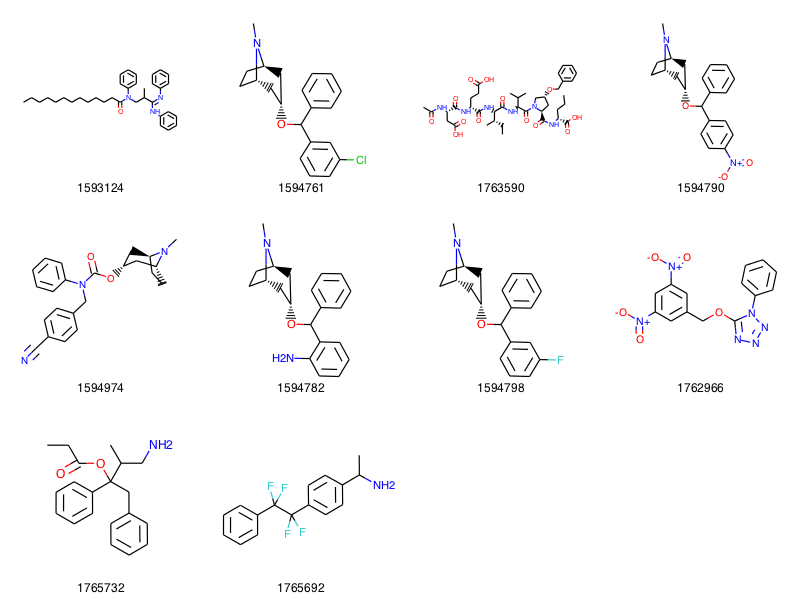

In [8]:
data = %sql  \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>:sma ::qmol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

Let's wrap that in a function and add a couple of additional parameters for even more control

In [9]:
def adjustQuery(m,ringsOnly=True,ignoreDummies=True):
    qm =Chem.RWMol(m)
    if ringsOnly:           
        ri = qm.GetRingInfo()
        try:
            ri.NumRings()
        except RuntimeError:
            ri=None
            Chem.FastFindRings(qm)
            ri = qm.GetRingInfo()
    for atom in qm.GetAtoms():
        if ignoreDummies and not atom.GetAtomicNum():
            continue
        if ringsOnly and not ri.NumAtomRings(atom.GetIdx()):
            continue

        oa = atom
        if not atom.HasQuery():
            needsReplacement=True
            atom = rdqueries.AtomNumEqualsQueryAtom(oa.GetAtomicNum())
            atom.ExpandQuery(rdqueries.IsAromaticQueryAtom(oa.GetIsAromatic()))
            if(oa.GetIsotope()):
                atom.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(oa.GetIsotope()))
            if(oa.GetFormalCharge()):
                atom.ExpandQuery(rdqueries.FormalChargeEqualsQueryAtom(oa.GetFormalCharge()))
        else:
            needsReplacement=False
        atom.ExpandQuery(rdqueries.ExplicitDegreeEqualsQueryAtom(oa.GetDegree()))
        if needsReplacement:
            qm.ReplaceAtom(oa.GetIdx(),atom)            
    return qm

Try it out:

Result SMARTS: [c&D2]1:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D3]:,-1-,:*
10 rows affected.


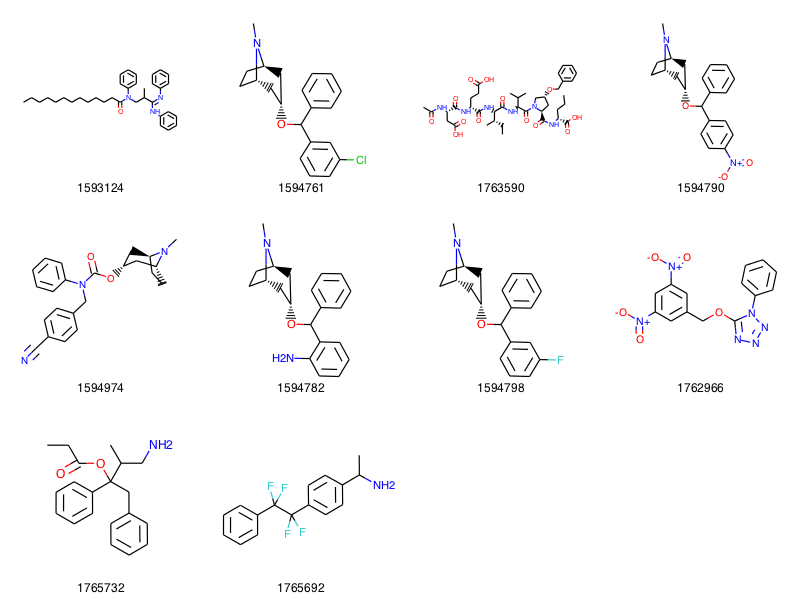

In [10]:
qm = adjustQuery(Chem.MolFromSmarts('c1ccccc1*'))
sma = Chem.MolToSmarts(qm)
print("Result SMARTS:",sma)
data = %sql  \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>:sma ::qmol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

Another use case: a phenyl ring that should have an oxygen substituent meta to another substituent:

Result SMARTS: O-,:[c&D3]1:,-[c&D2]:,-[c&D3](-,:*):,-[c&D2]:,-[c&D2]:,-[c&D2]:,-1
10 rows affected.


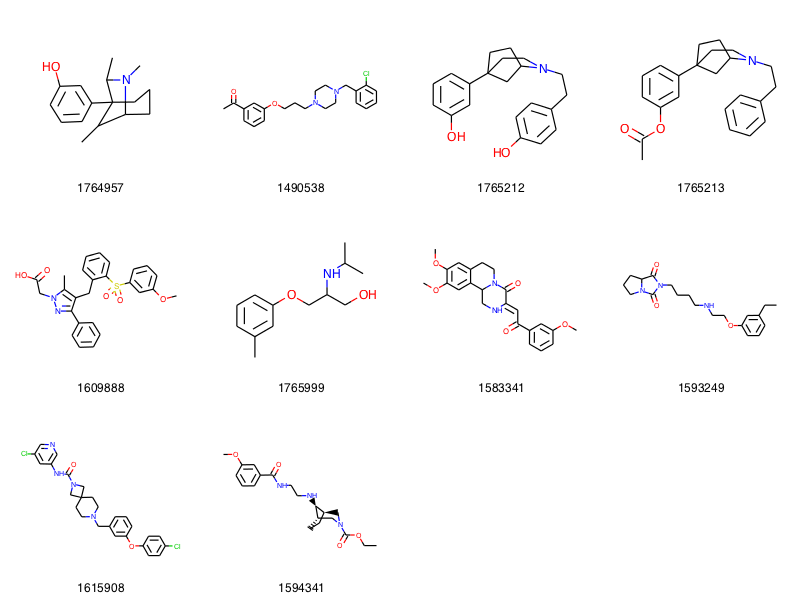

In [11]:
sma = 'Oc1cc(*)ccc1'
qm = adjustQuery(Chem.MolFromSmarts(sma))
sma = Chem.MolToSmarts(qm)
print("Result SMARTS:",sma)
data = %sql  \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>:sma ::qmol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

Notice that we're getting ethers and esters as well as alcohols. We can fix that by either adding an H to the O query or by telling `adjustQuery()` to not ignore non-ring atoms:

Result SMARTS: [O&D1]-,:[c&D3]1:,-[c&D2]:,-[c&D3](-,:*):,-[c&D2]:,-[c&D2]:,-[c&D2]:,-1
10 rows affected.


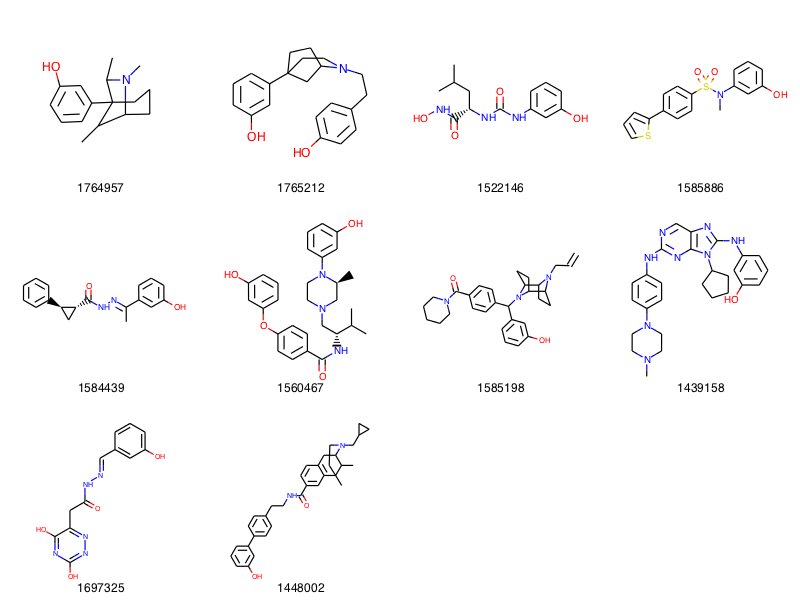

In [12]:
sma = 'Oc1cc(*)ccc1'
qm = adjustQuery(Chem.MolFromSmarts(sma),ringsOnly=False)
sma = Chem.MolToSmarts(qm)
print("Result SMARTS:",sma)
data = %sql  \
    select molregno,molfile from rdk.mols join compound_structures using (molregno) where m@>:sma ::qmol limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

The `adjustQuery()` function is, in some form, going to make it into the RDKit C++ code for the next release so that it's available from the cartridge as well as Python. 

I still need to figure out what the API should be (which options should be avaiable). Suggestions are welcome, either as comments here or on the github ticket: https://github.com/rdkit/rdkit/issues/567